The `Timedelta` object is relatively new to pandas. Recently I found myself wanting to work with timedeltas but finding that it wasn't obvious how to do the operations I wanted to perform. Worse, I found that some operations were seemingly obvious but could return the wrong answer **link to overflow section**. Here I go through some timedelta operations, hoping to provide a useful companion referenece to the [official documentation](http://pandas.pydata.org/pandas-docs/dev/timedeltas.html). 

## The Data
I decided to get data on Old Faithful Eruptions from [here](http://www.geyserstudy.org/geyser.aspx?pGeyserNo=OLDFAITHFUL) to serve as interesting timedeltas (credit to Yellowstone National Park and Ralph Taylor). See the shell commands below for how I downloaded and cleaned the files. 

```shell
wget http://www.geyserstudy.org/geysers/OLDFAITHFUL/eruptions/Old%20Faithful%20eruptions%20for%20200{0..9}.TXT
wget http://www.geyserstudy.org/geysers/OLDFAITHFUL/eruptions/Old%20Faithful%20eruptions%20for%2020{10..11}.TXT
# remove file headers by finding lines that begin with two numbers and a slash
grep -h '^\d\{2\}/' Old\ Faithful\ eruptions\ for\ 20* > old_faithful_data.csv
```

In [56]:
import pandas as pd
import numpy as np
import matplotlib
plt = matplotlib.pyplot
%matplotlib inline
matplotlib.style.use('ggplot')

The data has two columns, the date and time of the observed eruption and the elapsed time since the last eruption.

In [17]:
old_faithful_data = pd.read_csv('data/old_faithful_data.csv', header=None,
                               names=['date', 'elapsed_time'])
old_faithful_data.head(3)

,date,elapsed_time
0,10/11/00 13:56:55,0:00:00
1,10/11/00 15:17:55,1:21:00
2,10/11/00 16:40:55,1:23:00


## Summary statistics
Here I calculcate the difference between eruptions from the observed time directly.

In [31]:
eruption_times = pd.to_datetime(old_faithful_data['date'].str.strip(), 
                                format='%m/%d/%y %H:%M:%S')
eruption_deltas = eruption_times.diff()
eruption_deltas.describe()

count                     58514
mean     0 days 01:37:28.132634
std      0 days 10:28:02.853149
min             0 days 00:00:00
25%             0 days 01:28:00
50%             0 days 01:32:00
75%             0 days 01:36:00
max            79 days 00:12:00
Name: date, dtype: object

## Filtering timedeltas
It looks like there might be some bad data, the longest record is over 79 days. For the rest of the analysis I'll filter out everything longer than 3 hours. Although some of these long events may be signifigant they clearly don't represent the usual behavior. It's always important to look at more than just the mean of dataset like this since a few outliers can have a large effect on its value.

In [32]:
eruption_deltas = eruption_deltas[eruption_deltas < pd.Timedelta(hours=3)].dropna()
eruption_deltas.describe()

count                     58492
mean     0 days 01:31:31.356698
std      0 days 00:08:37.076579
min             0 days 00:00:00
25%             0 days 01:28:00
50%             0 days 01:32:00
75%             0 days 01:36:00
max             0 days 02:45:00
Name: date, dtype: object

## Histograms of timedeltas
The summary table above is nice, but I'd like to visualize the data in a histogram. Unfortunately a simple `eruption_deltas.hist()` call produces a `TypeError`, `hist()` can't be used on Timedeltas. Luckily there is a simple way to produce a histogram by converting the type of the series (what the documentation calls [freqency conversion](http://pandas.pydata.org/pandas-docs/stable/timedeltas.html#frequency-conversion)) and making a histogram of the result. Below I show two different conversion methods:

1. Using `.astype()` and supplying a string argument of the form 'timedelta64[unit]' where unit can be 's' for seconds, 'h' for hours, 'D' for days, etc. Any decimal part of the result will be discarded (floor division).
1. Dividing by a `Timedelta`. Any value of timedelta will work, so if you want to find out how many time you could have listened to <a href="http://en.wikipedia.org/wiki/Piano_Man_(song)">Piano Man</a> during each Timedelta, you could do `my_timedelta_series / pd.Timedelta(minutes=5, seconds=38)`.

In [48]:
print "Data as Timedelta:"
print eruption_deltas.head(3)
print ""
print "Data converted to the floor of the total hours (astype()):"
print (eruption_deltas.astype('timedelta64[h]')).head(3)
print ""
print "Data converted to total hours (/):"
print (eruption_deltas / pd.Timedelta(hours=1)).head(3)
print ""
print "Number of times you could listen to Piano Man between eruptions:"
print (eruption_deltas / pd.Timedelta(minutes=5, seconds=39)).head(3)

Data as Timedelta:
1   01:21:00
2   01:23:00
3   01:29:00
Name: date, dtype: timedelta64[ns]

Data converted to the floor of the total hours in the timedelta (astype()):
1    1
2    1
3    1
Name: date, dtype: float64

Data converted to total hours in the timedelta (/):
1    1.350000
2    1.383333
3    1.483333
Name: date, dtype: float64

Number of times you could listen to Piano Man between eruptions:
1    14.336283
2    14.690265
3    15.752212
Name: date, dtype: float64


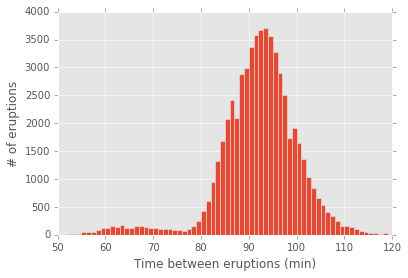

In [62]:
(eruption_deltas / pd.Timedelta(minutes=1)).hist(bins=xrange(50, 120, 1))
plt.xlabel('Time between eruptions (min)')
plt.ylabel('# of eruptions');

## Beware of overflow!
Timedeltas are stored under the hood with nanosecond percision as 64-bit integers. It turns out it is relatively easy to run into overflow issues, possibly without noticing (see more discussion [here](https://github.com/pydata/pandas/issues/9442)).

For example, lets look at the average time between days for the first 2,015 years of the common era (ignoring corrections for leap years):

In [65]:
common_era = pd.Series([pd.Timedelta(days=1)] * 2015 * 365)
common_era.mean()

Timedelta('0 days 03:05:55.794253')

The average time between days comes out to about **3 hours and 6 minutes**. My how time flies!

Here's what's happening. One day is 8.64E13 nanoseconds:

In [68]:
day_delta = pd.Timedelta(days=1)
print "{:,}".format(day_delta.value)

86,400,000,000,000


A signed 64-bit integer can hold only 106,751 of these day-long timedeltas:

In [69]:
(2**63 - 1) / day_delta.value

106751L

Calculation of the mean works fine for this many days, but overflow occurs if we add one more:

In [70]:
all_good_num_days = 106751
overflow_num_days = all_good_num_days + 1
all_good = pd.Series([pd.Timedelta(days=1)] * all_good_num_days)
print 'Mean time between the last {:,} days: {}'.format(all_good_num_days, all_good.mean())
overflow = pd.Series([pd.Timedelta(days=1)] * overflow_num_days)
print 'Mean time between the last {:,} days: {}'.format(overflow_num_days, overflow.mean())

Mean time between the last 106,751 days: 1 days 00:00:00
Mean time between the last 106,752 days: -1 days +00:00:00.014297


This can be overcome by converting the data to a lower precision, performing the operation you need, then creating a `Timedelta` from the result:

In [72]:
pd.Timedelta((overflow / pd.Timedelta(microseconds=1)).mean(), unit='us')

Timedelta('1 days 00:00:00')